Saving nba_traditional_stats_2024_2025.csv to nba_traditional_stats_2024_2025 (2).csv
Using file: nba_traditional_stats_2024_2025 (2).csv
Rows loaded: 569
Filtered to 360 rows


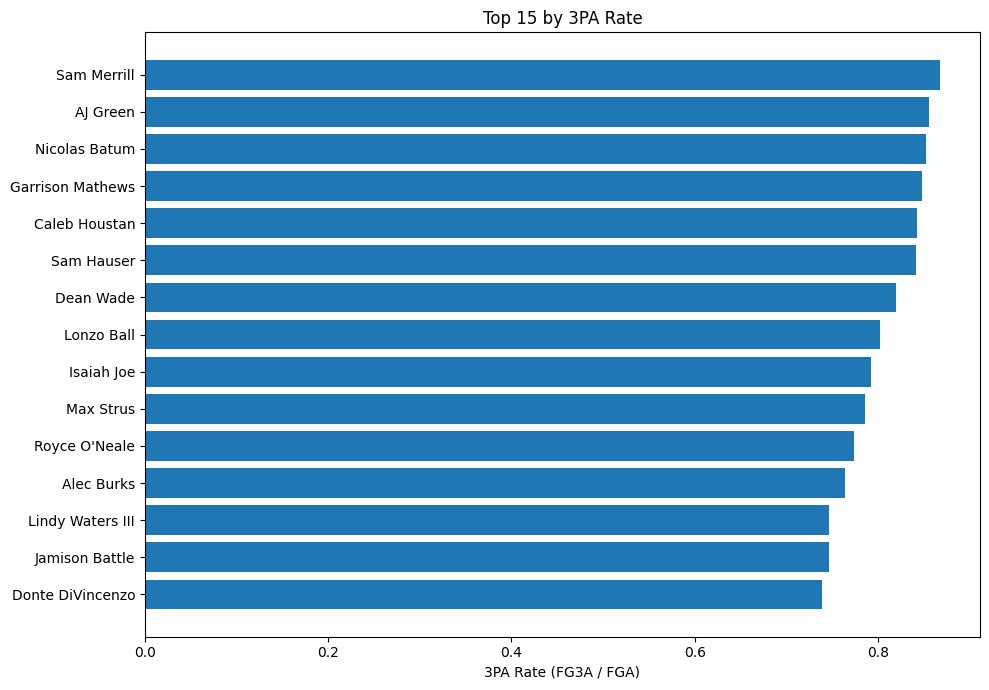

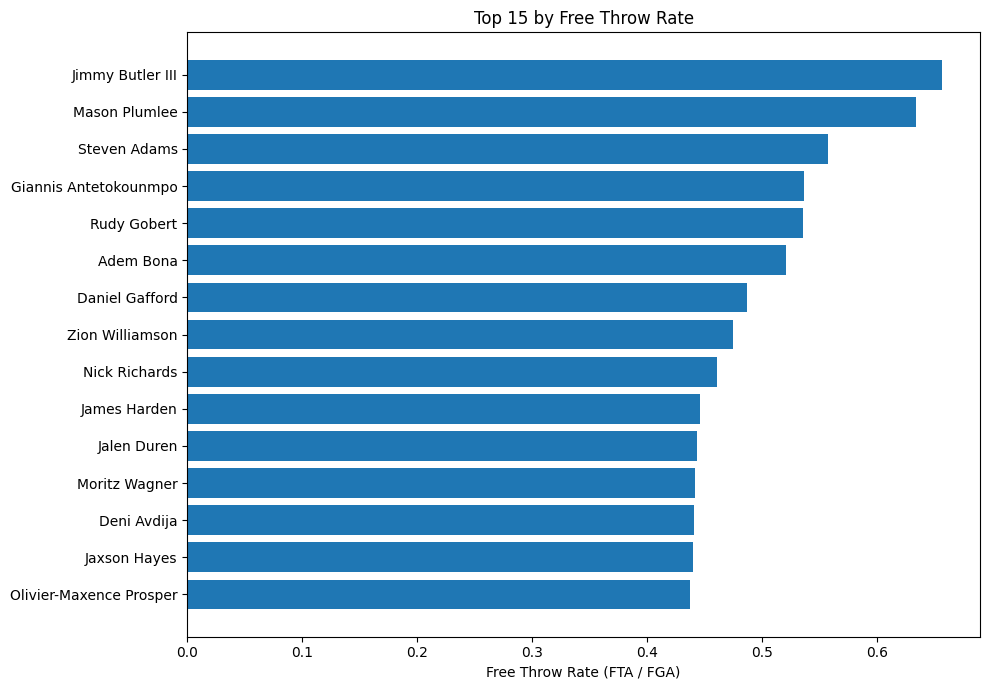

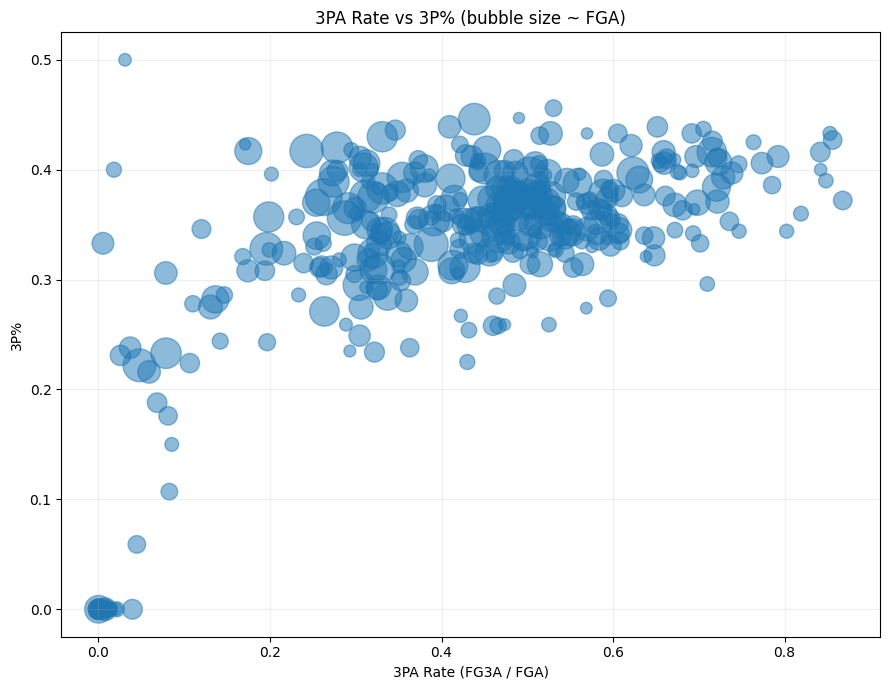

Saved CSVs: shot_profile_clean.csv, leaders_3pa_rate.csv, leaders_ftr.csv, leaders_2pa_rate.csv


In [5]:
# 🏀 Shot Profile (Basic) — Colab Ready

# =========================================
# 1) Imports
# =========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", None)

from google.colab import files
uploaded = files.upload()
file_path = list(uploaded.keys())[0]  # this will be your file
print("Using file:", file_path)

df = pd.read_csv(file_path)
df.columns = [c.strip() for c in df.columns]

if "Season Type" in df.columns:
    df["Season Type"] = df["Season Type"].astype(str).str.replace("%20", " ", regex=False)

num_cols = ["GP","MIN","FGM","FGA","FG3M","FG3A","FTM","FTA","FG_PCT","FG3_PCT","FT_PCT",
            "OREB","DREB","REB","AST","STL","BLK","TOV","PF","PTS","EFF","AST_TOV","STL_TOV"]
for c in num_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

essentials = ["Year","Season Type","PLAYER","TEAM","GP","MIN","FGA","FG3A","FTA"]
df = df.dropna(subset=essentials).copy()
print("Rows loaded:", len(df))
df.head()

# =========================================
# 4) Filters
# =========================================
target_year = None                # e.g., "2024-25" or None
target_season_type = "Regular Season"  # or "Playoffs" or None

MIN_GP = 20
MIN_MINUTES = 300
MIN_FGA = 150

df_use = df.copy()
if target_year is not None:
    df_use = df_use[df_use["Year"] == target_year]
if target_season_type is not None:
    df_use = df_use[df_use["Season Type"].str.lower() == target_season_type.lower()]

df_use = df_use[(df_use["GP"] >= MIN_GP) & (df_use["MIN"] >= MIN_MINUTES) & (df_use["FGA"] >= MIN_FGA)].copy()
print(f"Filtered to {len(df_use)} rows")
df_use.head()

# =========================================
# 5) Build Shot Profile
# =========================================
df_use["2PA"] = df_use["FGA"] - df_use["FG3A"]
df_use["TwoPA_rate"] = np.where(df_use["FGA"] > 0, df_use["2PA"] / df_use["FGA"], np.nan)
df_use["ThreePA_rate"] = np.where(df_use["FGA"] > 0, df_use["FG3A"] / df_use["FGA"], np.nan)
df_use["FTr"] = np.where(df_use["FGA"] > 0, df_use["FTA"] / df_use["FGA"], np.nan)
df_use["Three_to_Two_Ratio"] = np.where(df_use["2PA"] > 0, df_use["FG3A"] / df_use["2PA"], np.inf)

cols_out = ["Year","Season Type","PLAYER","TEAM","GP","MIN","FGA","FG3A","2PA","FG_PCT","FG3_PCT","FT_PCT",
            "ThreePA_rate","TwoPA_rate","FTr","Three_to_Two_Ratio","PTS","EFF"]
shot_profile = df_use[cols_out].sort_values(["Year","Season Type","PLAYER"]).reset_index(drop=True)
shot_profile.head()

# =========================================
# 6) Leaderboards
# =========================================
MIN_3PA = 100
leaders_3par = (df_use[df_use["FG3A"] >= MIN_3PA]
                .sort_values("ThreePA_rate", ascending=False)
                .loc[:, ["PLAYER","TEAM","Year","Season Type","FGA","FG3A","ThreePA_rate","FG3_PCT"]]
                .head(20))

leaders_ftr = (df_use.sort_values("FTr", ascending=False)
               .loc[:, ["PLAYER","TEAM","Year","Season Type","FGA","FTA","FTr","FG_PCT"]]
               .head(20))

leaders_2par = (df_use.sort_values("TwoPA_rate", ascending=False)
                .loc[:, ["PLAYER","TEAM","Year","Season Type","FGA","2PA","TwoPA_rate","FG_PCT"]]
                .head(20))

leaders_3par.head(10), leaders_ftr.head(10), leaders_2par.head(10)

# =========================================
# 7) Plots
# =========================================
topN = 15

# Top 3PA Rate
plot_df = leaders_3par.head(topN).copy()
plt.figure(figsize=(10, 7))
plt.barh(plot_df["PLAYER"][::-1], plot_df["ThreePA_rate"][::-1])
plt.xlabel("3PA Rate (FG3A / FGA)")
plt.title(f"Top {topN} by 3PA Rate")
plt.tight_layout()
plt.show()

# Top FTr
plot_df = leaders_ftr.head(topN).copy()
plt.figure(figsize=(10, 7))
plt.barh(plot_df["PLAYER"][::-1], plot_df["FTr"][::-1])
plt.xlabel("Free Throw Rate (FTA / FGA)")
plt.title(f"Top {topN} by Free Throw Rate")
plt.tight_layout()
plt.show()

# Scatter: 3PA Rate vs 3P%
sc = df_use.dropna(subset=["ThreePA_rate","FG3_PCT"]).copy()
plt.figure(figsize=(9, 7))
sizes = np.clip(sc["FGA"] / sc["FGA"].max() * 700, 20, 700)
plt.scatter(sc["ThreePA_rate"], sc["FG3_PCT"], s=sizes, alpha=0.5)
plt.xlabel("3PA Rate (FG3A / FGA)")
plt.ylabel("3P%")
plt.title("3PA Rate vs 3P% (bubble size ~ FGA)")
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

# =========================================
# 8) Save Outputs
# =========================================
shot_profile.to_csv("shot_profile_clean.csv", index=False)
leaders_3par.to_csv("leaders_3pa_rate.csv", index=False)
leaders_ftr.to_csv("leaders_ftr.csv", index=False)
leaders_2par.to_csv("leaders_2pa_rate.csv", index=False)

print("Saved CSVs: shot_profile_clean.csv, leaders_3pa_rate.csv, leaders_ftr.csv, leaders_2pa_rate.csv")